<a href="https://colab.research.google.com/github/robsonbrandao/artigos/blob/main/05%20-%20Apache%20Spark%20-%20Consultas%20Analiticas%20/Consultas_Anal%C3%ADticas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style="color:blue">Processamento Analítico de Dados em Larga Escala</span>

## <span style="color:blue">Aula 04: Módulo pyspark.sql e Discussões Finais</span>
## <span style="color:blue">Módulo pyspark.sql: Notebook com Consultas Analíticas</span>


**ICMC/USP**

**IMPORTANTE: O uso do *framework* Spark requer diversas configurações no ambiente de desenvolvimento para executar o *notebook*. Dado que tal complexidade foge do escopo de nossa disciplina, recomenda-se que o *notebook* seja executado na plataforma de desenvolvimento COLAB. O uso do COLAB  proporciona um ambiente de desenvolvimento pré-configurado e remove a complexidade de instalação e configuração de pacotes e *frameworks* que são utilizados na disciplina.** 

# 1 Constelação de Fatos da Celeb Co.

A aplicação de *data warehousing* da Celeb Co. utiliza como base uma contelação de fatos, conforme descrita a seguir.

**Tabelas de dimensão**

- data (dataPK, dataCompleta, dataDia, dataMes, dataBimestre, dataTrimestre, dataSemestre, dataAno)
- funcionario (funcPK, funcMatricula, funcNome, funcSexo, funcDataNascimento, funcDiaNascimento, funcMesNascimento, funcAnoNascimento, funcCidade, funcEstadoNome, funcEstadoSigla, funcRegiaoNome, funcRegiaoSigla, funcPaisNome, funcPaisSigla)
- equipe (equipePK, equipeNome, filialNome, filialCidade, filialEstadoNome, filialEstadoSigla, filialRegiaoNome, filialRegiaoSigla, filialPaisNome, filialPaisSigla)
- cargo (cargoPK, cargoNome, cargoRegimeTrabalho, cargoEscolaridadeMinima, cargoNivel)
- cliente (clientePK, clienteNomeFantasia, clienteSetor, clienteCidade, clienteEstadoNome, clienteEstadoSigla, clienteRegiaoNome, clienteRegiaoSigla, clientePaisNome, clientePaisSigla)

**Tabelas de fatos**
- pagamento (dataPK, funcPK, equipePK, cargoPK, salario, quantidadeLancamentos)
- negociacao (dataPK, equipePK, clientePK, receita, quantidadeNegociacoes)


#2 Obtenção dos Dados


## 2.1 Instalando o Módulo wget

Para obter os dados referentes ao esquema relacional da constelação de fatos da Celeb Co., é utilizado o módulo  **wget**. O comando a seguir realiza a instalação desse módulo. <br>

In [ ]:
# instalando o módulo wget
%%capture
!pip install -q wget

# criando uma pasta para salvar os dados das relações
!mkdir data

# importando o módulo wget
import wget

## 2.2 Tabelas de Dimensão

Os comandos a seguir obtêm os dados que povoam as tabelas de dimensão. 

In [ ]:
# obtendo os dados da tabela de dimensão data
url = "https://raw.githubusercontent.com/CristinaAguiar/DataMartCelebCo/main/data.csv"
wget.download(url, "data/data.csv")

# obtendo os dados da tabela de dimensão funcionario
url = "https://raw.githubusercontent.com/CristinaAguiar/DataMartCelebCo/main/funcionario.csv"
wget.download(url, "data/funcionario.csv")

# obtendo os dados da tabela de dimensão equipe
url = "https://raw.githubusercontent.com/CristinaAguiar/DataMartCelebCo/main/equipe.csv"
wget.download(url, "data/equipe.csv")

# obtendo os dados da tabela de dimensão cargo
url = "https://raw.githubusercontent.com/CristinaAguiar/DataMartCelebCo/main/cargo.csv"
wget.download(url, "data/cargo.csv")

# obtendo os dados da tabela de dimensão cliente
url = "https://raw.githubusercontent.com/CristinaAguiar/DataMartCelebCo/main/cliente.csv"
wget.download(url, "data/cliente.csv")

'data/cliente.csv'

## 2.3 Tabelas de Fatos

Os comandos a seguir obtêm os dados que povoam as tabelas de fatos. 

In [ ]:
# obtendo os dados da tabela de fatos pagamento
url = "https://raw.githubusercontent.com/CristinaAguiar/DataMartCelebCo/main/pagamento.csv"
wget.download(url, "data/pagamento.csv")

# obtendo os dados da tabela de fatos negociacao
url = "https://raw.githubusercontent.com/CristinaAguiar/DataMartCelebCo/main/negociacao.csv"
wget.download(url, "data/negociacao.csv")

'data/negociacao.csv'

# 3 Apache Spark Cluster

## 3.1 Instalação

Neste *notebook* é criado um *cluster* Spark composto apenas por um **nó mestre**. Ou seja, o *cluster* não possui um ou mais **nós de trabalho** e o **gerenciador de cluster**. Nessa configuração, as tarefas (*tasks*) são realizadas no próprio *driver* localizado no **nó mestre**.

Para que o cluster possa ser criado, primeiramente é instalado o Java Runtime Environment (JRE) versão 8. 

In [ ]:
#instalando Java Runtime Environment (JRE) versão 8
%%capture
!apt-get remove openjdk*
!apt-get update --fix-missing
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Na sequência, é feito o *download* do Apache Spark versão 3.0.0.

In [ ]:
#baixando Apache Spark versão 3.0.0
%%capture
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop2.7.tgz
!tar xf spark-3.0.0-bin-hadoop2.7.tgz && rm spark-3.0.0-bin-hadoop2.7.tgz

Na sequência, são configuradas as variáveis de ambiente JAVA_HOME e SPARK_HOME. Isto permite que tanto o Java quanto o Spark possam ser encontrados.

In [ ]:
import os

# configurando a variável de ambiente JAVA_HOME
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# configurando a variável de ambiente SPARK_HOME
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop2.7"

Por fim, são instalados dois pacotes da linguagem de programação Python, cujas funcionalidades são descritas a seguir.

> **Pacote findspark:** Usado para ler a variável de ambiente SPARK_HOME e armazenar seu valor na variável dinâmica de ambiente PYTHONPATH. Como resultado, Python pode encontrar a instalação do Spark. 

> **Pacote pyspark:** PySpark é a API do Python para Spark. Ela possibilita o uso de Python, considerando que o *framework* Apache Spark encontra-se desenvolvido na linguagem de programação Scala. 

In [ ]:
%%capture

#instalando o pacote findspark
!pip install -q findspark==1.4.2

#instalando o pacote pyspark
!pip install -q pyspark==3.0.0

## 3.2 Conexão

PySpark não é adicionado ao *sys.path* por padrão. Isso significa que não é possível importá-lo, pois o interpretador da linguagem Python não sabe onde encontrá-lo. 

Para resolver esse aspecto, é necessário instalar o módulo `findspark`. Esse módulo mostra onde PySpark está localizado. Os comandos a seguir têm essa finalidade.


In [ ]:
# importando o módulo findspark
import findspark

# carregando a variávels SPARK_HOME na variável dinâmica PYTHONPATH
findspark.init()

## 3.3 Criação da SparkSession 

Depois de configurados os pacotes e módulos e inicializadas as variáveis de ambiente, é possível iniciar o uso do Spark na aplicação de `data warehousing`. Para tanto, é necessário importar o comando `SparkSession` do módulo `pyspark.sql`. São utilizados os seguintes conceitos: <br>

- `SparkSession`: permite a criação de `DataFrames`. Como resultado, as tabelas relacionais podem ser manipuladas por meio de `DataFrames` e é possível realizar consultas OLAP por meio de comandos SQL. <br>
- `builder`: cria uma instância de SparkSession. <br>
- `appName`: define um nome para a aplicação, o qual pode ser visto na interface de usuário web do Spark. <br> 
- `master`: define onde está o nó mestre do *cluster*. Como a aplicação é executada localmente e não em um *cluster*, indica-se isso pela *string* `local` seguida do parâmetro `[*]`. Ou seja, define-se que apenas núcleos locais são utilizados. 
- `getOrCreate`: cria uma SparkSession. Caso ela já exista, retorna a instância existente. 


**Observação**: A lista completa de todos os parâmetros que podem ser utilizados na inicialização do *cluster* pode ser encontrada neste [link](https://spark.apache.org/docs/latest/spark-standalone.html#cluster-launch-scripts).

In [ ]:
# criando SparkSession
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("pyspark-notebook").master("local[*]").getOrCreate()

# 4 Geração dos DataFrames

Um `DataFrame` em Spark é equivalente a uma tabela relacional. Portanto, um `DataFrame` possui um esquema, uma ou mais linhas (ou tuplas) e uma ou mais colunas (ou atributos).


## 4.1 Criação dos DataFrames

Para a leitura dos dados dos arquivos .csv, é utilizado o método `spark.read.csv`. Seus parâmetros são:


- `path`: endereço do arquivo que é lido.
- `header`: indica se o arquivo possui um cabeçalho.
- `sep`: especifica o caractere que separa os campos do arquivo.

### 4.1.1 Tabelas de Dimensão

In [ ]:
#criando e exibindo o DataFrame para a tabela de dimensão cargo
cargo = spark.read.csv(path="data/cargo.csv", header=True, sep=",")
cargo.show(5)
cargo.printSchema()


+-------+----------+-------------------+--------------------+-----------------------+----------+
|cargoPK| cargoNome|cargoRegimeTrabalho|cargoJornadaTrabalho|cargoEscolaridadeMinima|cargoNivel|
+-------+----------+-------------------+--------------------+-----------------------+----------+
|      1|COZINHEIRO|         TEMPORARIO|                 20H|                  MEDIO|    JUNIOR|
|      2|COZINHEIRO|         TEMPORARIO|                 20H|               SUPERIOR|     PLENO|
|      3|COZINHEIRO|         TEMPORARIO|                 20H|                    POS|    SENIOR|
|      4|COZINHEIRO|         TEMPORARIO|                 40H|                  MEDIO|    JUNIOR|
|      5|COZINHEIRO|         TEMPORARIO|                 40H|               SUPERIOR|     PLENO|
+-------+----------+-------------------+--------------------+-----------------------+----------+
only showing top 5 rows

root
 |-- cargoPK: string (nullable = true)
 |-- cargoNome: string (nullable = true)
 |-- cargoRegimeT

In [ ]:
#criando e exibindo o DataFrame para a tabela de dimensão cliente
cliente = spark.read.csv(path="data/cliente.csv", header=True, sep=",")
cliente.show(5)
cliente.printSchema()

+---------+-------------------+------------+-------------+-----------------+------------------+-----------------+------------------+---------------+----------------+
|clientePK|clienteNomeFantasia|clienteSetor|clienteCidade|clienteEstadoNome|clienteEstadoSigla|clienteRegiaoNome|clienteRegiaoSigla|clientePaisNome|clientePaisSigla|
+---------+-------------------+------------+-------------+-----------------+------------------+-----------------+------------------+---------------+----------------+
|        1|           VIA FOOD| ALIMENTACAO|    SAO PAULO|        SAO PAULO|                SP|          SUDESTE|                SE|         BRASIL|              BR|
|        2|          VIA PIZZA| ALIMENTACAO|    SAO PAULO|        SAO PAULO|                SP|          SUDESTE|                SE|         BRASIL|              BR|
|        3|           VIA JAPA| ALIMENTACAO|    SAO PAULO|        SAO PAULO|                SP|          SUDESTE|                SE|         BRASIL|              BR|
|   

In [ ]:
#criando e exibindo o DataFrame para a tabela de dimensão data
data = spark.read.csv(path="data/data.csv", header=True, sep=",") 
data.show(5)
data.printSchema()

+------+------------+-------+-------+------------+-------------+------------+-------+
|dataPK|dataCompleta|dataDia|dataMes|dataBimestre|dataTrimestre|dataSemestre|dataAno|
+------+------------+-------+-------+------------+-------------+------------+-------+
|     1|  01/01/2017|      1|      1|           1|            1|           1|   2017|
|     2|  02/01/2017|      2|      1|           1|            1|           1|   2017|
|     3|  03/01/2017|      3|      1|           1|            1|           1|   2017|
|     4|  04/01/2017|      4|      1|           1|            1|           1|   2017|
|     5|  05/01/2017|      5|      1|           1|            1|           1|   2017|
+------+------------+-------+-------+------------+-------------+------------+-------+
only showing top 5 rows

root
 |-- dataPK: string (nullable = true)
 |-- dataCompleta: string (nullable = true)
 |-- dataDia: string (nullable = true)
 |-- dataMes: string (nullable = true)
 |-- dataBimestre: string (nullable 

In [ ]:
#criando e exibindo o DataFrame para a tabela de dimensão equipe
equipe = spark.read.csv(path="data/equipe.csv", header=True, sep=",")
equipe.show(5)
equipe.printSchema()

+--------+-------------+--------------------+--------------+------------------+-----------------+----------------+-----------------+--------------+---------------+
|equipePK|   equipeNome|          filialNome|  filialCidade|  filialEstadoNome|filialEstadoSigla|filialRegiaoNome|filialRegiaoSigla|filialPaisNome|filialPaisSigla|
+--------+-------------+--------------------+--------------+------------------+-----------------+----------------+-----------------+--------------+---------------+
|       1| SERVICO PLUS|SAO PAULO - IPIRANGA|     SAO PAULO|         SAO PAULO|               SP|         SUDESTE|               SE|        BRASIL|             BR|
|       2| SERVICO PLUS|RIO DE JANEIRO - ...|RIO DE JANEIRO|    RIO DE JANEIRO|               RJ|         SUDESTE|               SE|        BRASIL|             BR|
|       3|SERVICO BASIC|SAO PAULO - IPIRANGA|     SAO PAULO|         SAO PAULO|               SP|         SUDESTE|               SE|        BRASIL|             BR|
|       4|SERVIC

In [ ]:
#criando e exibindo o DataFrame para a tabela de fatos funcionario
funcionario = spark.read.csv(path="data/funcionario.csv", header=True, sep=",")
funcionario.show(5)
funcionario.printSchema()

+------+-------------+------------------+--------+------------------+-----------------+-----------------+-----------------+-----------+--------------+---------------+--------------+---------------+------------+-------------+
|funcPK|funcMatricula|          funcNome|funcSexo|funcDataNascimento|funcDiaNascimento|funcMesNascimento|funcAnoNascimento| funcCidade|funcEstadoNome|funcEstadoSigla|funcRegiaoNome|funcRegiaoSigla|funcPaisNome|funcPaisSigla|
+------+-------------+------------------+--------+------------------+-----------------+-----------------+-----------------+-----------+--------------+---------------+--------------+---------------+------------+-------------+
|     1|          M-1|MARGARET HENDERSON|       F|        01/01/1992|                1|                1|             1992|  SAO PAULO|     SAO PAULO|             SP|       SUDESTE|             SE|      BRASIL|           BR|
|     2|          M-2|       LLOYD UPTON|       M|        02/02/1992|                2|             

### 4.1.2 Tabelas de Fatos

In [ ]:
#criando e exibindo o DataFrame para a tabela de fatos negociacao
negociacao = spark.read.csv(path="data/negociacao.csv", header=True, sep=",")
negociacao.show(5)
negociacao.printSchema()

+--------+---------+------+--------+---------------------+
|equipePK|clientePK|dataPK| receita|quantidadeNegociacoes|
+--------+---------+------+--------+---------------------+
|       2|        9|    22|11525.24|                    1|
|       2|       24|    11|17509.43|                    1|
|       2|       28|    21|16195.76|                    1|
|       1|       30|    23|  7969.1|                    1|
|       2|       43|    30|23124.98|                    1|
+--------+---------+------+--------+---------------------+
only showing top 5 rows

root
 |-- equipePK: string (nullable = true)
 |-- clientePK: string (nullable = true)
 |-- dataPK: string (nullable = true)
 |-- receita: string (nullable = true)
 |-- quantidadeNegociacoes: string (nullable = true)



In [ ]:
#criando e exibindo o DataFrame para a tabela de fatos pagamento
pagamento = spark.read.csv(path="data/pagamento.csv", header=True, sep=",")
pagamento.show()
pagamento.printSchema()

+------+--------+------+-------+--------+---------------------+
|funcPK|equipePK|dataPK|cargoPK| salario|quantidadeLancamentos|
+------+--------+------+-------+--------+---------------------+
|   147|       2|     5|     64| 1299.95|                    1|
|   124|       2|     5|    329| 6752.31|                    1|
|   175|       1|     5|    328| 2110.43|                    1|
|   171|       1|     5|    245| 6568.92|                    1|
|   148|       2|     5|     65| 3670.49|                    1|
|     5|       2|     5|    112| 1855.55|                    1|
|   128|       1|     5|    341| 5130.87|                    1|
|    82|       2|     5|     43| 1321.26|                    1|
|    28|       1|     5|    253| 1328.35|                    1|
|    46|       1|     5|    390| 8233.47|                    1|
|    91|       2|     5|    233| 9109.56|                    1|
|   176|       2|     5|    241| 1671.24|                    1|
|   172|       1|     5|    351|11848.57

## 4.2 Atualização dos Tipos de Dados 

### 4.2.1 Tipo de Dados Inteiro

Nos comandos a seguir, primeiro são identificados quais colunas de quais `DataFrames` devem ser do tipo de dado inteiro. Na sequência, ocorre a conversão. 

In [ ]:
# identificando quais colunas de quais DataFrames devem ser do tipo de dado inteiro
colunas_cargo = ["cargoPK"]
colunas_cliente = ["clientePK"]
colunas_data = ["dataPk", "dataDia", "dataMes", "dataBimestre", "dataTrimestre", "dataSemestre", "dataAno"]
colunas_equipe = ["equipePK"]
colunas_funcionario = ["funcPK", "funcDiaNascimento", "funcMesNascimento", "funcAnoNascimento"]
colunas_negociacao = ["equipePK", "clientePK", "dataPK", "quantidadeNegociacoes"]
colunas_pagamento = ["funcPK", "equipePK", "dataPK", "cargoPK", "quantidadeLancamentos"]

In [ ]:
# importando o tipo de dado desejado
from pyspark.sql.types import IntegerType


# atualizando o tipo de dado das colunas especificadas 
# substituindo as colunas já existentes 

for coluna in colunas_cargo:
  cargo = cargo.withColumn(coluna, cargo[coluna].cast(IntegerType()))

for coluna in colunas_cliente:
  cliente = cliente.withColumn(coluna, cliente[coluna].cast(IntegerType()))

for coluna in colunas_data:
  data = data.withColumn(coluna, data[coluna].cast(IntegerType()))

for coluna in colunas_equipe:
  equipe = equipe.withColumn(coluna, equipe[coluna].cast(IntegerType()))

for coluna in colunas_funcionario:
  funcionario = funcionario.withColumn(coluna, funcionario[coluna].cast(IntegerType()))

for coluna in colunas_negociacao:
  negociacao = negociacao.withColumn(coluna, negociacao[coluna].cast(IntegerType()))

for coluna in colunas_pagamento:
  pagamento = pagamento.withColumn(coluna, pagamento[coluna].cast(IntegerType()))

### 4.2.2 Tipo de Dados de Ponto Flutuante

Nos comandos a seguir, primeiro são identificados quais colunas de quais `DataFrames` devem ser do tipo de dado número de ponto flutuante. Na sequência, ocorre a conversão. 

In [ ]:
# identificando quais colunas de quais DataFrames devem ser do tipo de dado número de ponto flutuante
colunas_negociacao = ["receita"]
colunas_pagamento = ["salario"]

In [ ]:
# importando o tipo de dado desejado
from pyspark.sql.types import FloatType


# atualizando o tipo de dado das colunas especificadas 
# substituindo as colunas já existentes 

for coluna in colunas_negociacao:
  negociacao = negociacao.withColumn(coluna, negociacao[coluna].cast(FloatType()))

for coluna in colunas_pagamento:
  pagamento = pagamento.withColumn(coluna, pagamento[coluna].cast(FloatType()))

# 5 Execução de Consultas com Foco nas Operações OLAP

## 5.1 Operação Slice and Dice 

**Definição**: Restringe os dados sendo analisados a um subconjunto desses dados.

- Slice: corte para um valor fixo, diminuindo a dimensionalidade do cubo.
- Dice: seleção de faixas de valores.

**Exemplo de consulta**: Qual a soma dos salários por data por funcionário para a equipe de código igual a 1?

In [ ]:
pagamento\
   .filter("equipePK = 1")\
   .groupBy("dataPK", "funcPK")\
   .sum("salario")\
   .orderBy("dataPK", "funcPK")\
   .show(5)

+------+------+------------------+
|dataPK|funcPK|      sum(salario)|
+------+------+------------------+
|     5|    28|1328.3499755859375|
|     5|    29|   3440.3701171875|
|     5|    33|    7641.580078125|
|     5|    34|  1361.02001953125|
|     5|    42|   10647.580078125|
+------+------+------------------+
only showing top 5 rows



**Visualização Gráfica**: Quais são os salários considerados?

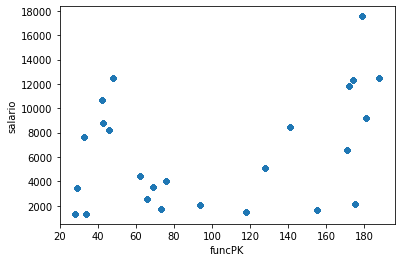

In [ ]:
# investigando os salários por funcionário
resposta = pagamento\
   .where("equipePK = 1")\
   .select("funcPK", "salario")

# transformando o resultado da consulta em Pandas
pagFiltrado = resposta.toPandas()

# exibindo a visualização gráfica
pagFiltrado.plot(kind = 'scatter', x = 'funcPK', y = 'salario')

## 5.2 Operações Drill-Down e Roll-Up

**Definição**: Analisam os dados considerando níveis progressivos de agregação.

- Drill-down: níveis de agregação progressivamente mais detalhados, ou de menor granularidade.
- Roll-up: níveis de agregação progressivamente menos detalhados, ou de maior granularidade.

Para ilustrar as operações de drill-down e roll-up, considere a consulta base definida a seguir.

**Consulta base:** Qual a soma dos salários por ano, considerando as **regiões** nas quais os funcionários moram?

In [ ]:
resposta = pagamento\
   .join(data, on="dataPK")\
   .join(funcionario, on="funcPK")\
   .groupBy("dataAno", "funcRegiaoNome")\
   .sum("salario")\
   .orderBy("dataAno", "funcRegiaoNome")

resposta.show()

+-------+--------------+--------------------+
|dataAno|funcRegiaoNome|        sum(salario)|
+-------+--------------+--------------------+
|   2017|      NORDESTE|    374050.072265625|
|   2017|       SUDESTE|  2747907.2373046875|
|   2017|           SUL|   580223.8681640625|
|   2018|      NORDESTE|   611876.7509765625|
|   2018|       SUDESTE|   6535495.079589844|
|   2018|           SUL|   998695.1821289062|
|   2019|      NORDESTE|  1077187.0737304688|
|   2019|       SUDESTE|   9174504.465820312|
|   2019|           SUL|   2194580.490234375|
|   2020|      NORDESTE|  1471546.6713867188|
|   2020|       SUDESTE|1.1471309506347656E7|
|   2020|           SUL|  2530199.1313476562|
|   2021|      NORDESTE|  1471546.6713867188|
|   2021|       SUDESTE|1.1471309506347656E7|
|   2021|           SUL|  2530199.1313476562|
+-------+--------------+--------------------+



**Visualização Gráfica**: Mostre na forma de um diagrama de barras o resultado obtido.

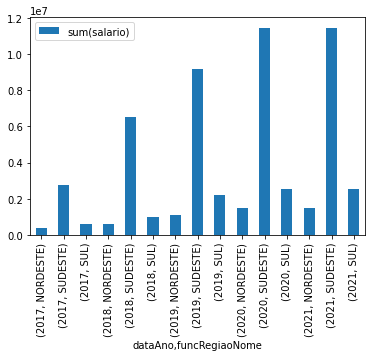

In [ ]:
# transformando o resultado da consulta em Pandas
pagAnoReg = resposta.toPandas()

# exibindo a visualização gráfica
# informando quais são os índices do DataFrame em Pandas 
pagAnoReg.set_index(['dataAno', 'funcRegiaoNome']).plot(kind = 'bar')

**Exemplo de consulta drill-down:** Qual a soma dos salários por ano, considerando os **estados** nos quais os funcionários moram?

In [ ]:
resposta = pagamento\
   .join(data, on="dataPK")\
   .join(funcionario, on="funcPK")\
   .groupBy("dataAno", "funcEstadoNome")\
   .sum("salario")\
   .orderBy("dataAno", "funcEstadoNome")

resposta.show()

+-------+--------------+------------------+
|dataAno|funcEstadoNome|      sum(salario)|
+-------+--------------+------------------+
|   2017|  MINAS GERAIS| 591903.5947265625|
|   2017|        PARANA| 580223.8681640625|
|   2017|    PERNAMBUCO|  374050.072265625|
|   2017|RIO DE JANEIRO| 471737.8857421875|
|   2017|     SAO PAULO|1684265.7568359375|
|   2018|  MINAS GERAIS| 733761.5947265625|
|   2018|        PARANA| 998695.1821289062|
|   2018|    PERNAMBUCO| 611876.7509765625|
|   2018|RIO DE JANEIRO|1268742.8452148438|
|   2018|     SAO PAULO|4532990.6396484375|
|   2019|  MINAS GERAIS|1269792.4716796875|
|   2019|        PARANA| 2194580.490234375|
|   2019|    PERNAMBUCO|1077187.0737304688|
|   2019|RIO DE JANEIRO|1530257.4067382812|
|   2019|     SAO PAULO| 6374454.587402344|
|   2020|  MINAS GERAIS|2416463.5166015625|
|   2020|        PARANA|2530199.1313476562|
|   2020|    PERNAMBUCO|1471546.6713867188|
|   2020|RIO DE JANEIRO|1837432.6904296875|
|   2020|     SAO PAULO| 7217413

**Visualização Gráfica**: Mostre na forma de um diagrama de barras o resultado obtido.

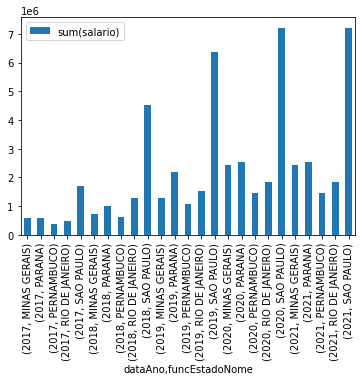

In [ ]:
# transformando o resultado da consulta em Pandas
pagAnoEstAgrega = resposta.toPandas()

# exibindo a visualização gráfica
# informando quais são os índices do DataFrame em Pandas 
pagAnoEstAgrega.set_index(['dataAno', 'funcEstadoNome']).plot(kind = 'bar')

**Exemplo de consulta roll-up:** Qual a soma dos salários por ano, considerando os **países** nos quais os funcionários moram?

In [ ]:
resposta = pagamento\
   .join(data, on="dataPK")\
   .join(funcionario, on="funcPK")\
   .groupBy("dataAno", "funcPaisNome")\
   .sum("salario")\
   .orderBy("dataAno", "funcPaisNome")

resposta.show()

+-------+------------+--------------------+
|dataAno|funcPaisNome|        sum(salario)|
+-------+------------+--------------------+
|   2017|      BRASIL|   3702181.177734375|
|   2018|      BRASIL|  8146067.0126953125|
|   2019|      BRASIL|1.2446272029785156E7|
|   2020|      BRASIL|1.5473055309082031E7|
|   2021|      BRASIL|1.5473055309082031E7|
+-------+------------+--------------------+



**Visualização Gráfica**: Mostre na forma de um diagrama de barras o resultado obtido.

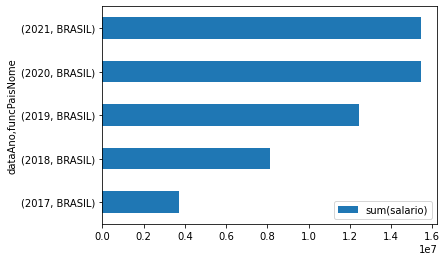

In [ ]:
# transformando o resultado da consulta em Pandas
pagAnoPaisAgrega = resposta.toPandas()

# exibindo a visualização gráfica
# informando quais são os índices do DataFrame em Pandas 
pagAnoPaisAgrega.set_index(['dataAno', 'funcPaisNome']).plot(kind = 'barh')

**Visualização Gráfica**: Mostre na forma de um diagrama de pizza o resultado obtido.

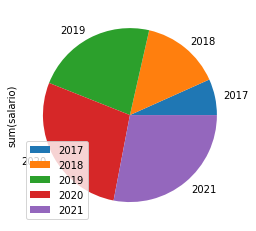

In [ ]:
# exibindo a visualização gráfica
# informando qual o índice do DataFrame em Pandas 
pagAnoPaisAgrega.set_index('dataAno').plot.pie(y = 'sum(salario)')

## 5.3 Operação Pivot

**Definição:** Reorienta a visão multidimensional dos dados, oferecendo diferentes perspectivas dos mesmos dados.

Para ilustrar a operação pivot, considere a consulta base definida a seguir. 

**Consulta base:** Qual a soma dos salários por ano, considerando as regiões nas quais os funcionários moram?

In [ ]:
resposta = pagamento\
   .join(data, on="dataPK")\
   .join(funcionario, on="funcPK")\
   .groupBy("dataAno", "funcRegiaoNome")\
   .sum("salario")\
   .orderBy("dataAno", "funcRegiaoNome")

resposta.show()

+-------+--------------+--------------------+
|dataAno|funcRegiaoNome|        sum(salario)|
+-------+--------------+--------------------+
|   2017|      NORDESTE|    374050.072265625|
|   2017|       SUDESTE|  2747907.2373046875|
|   2017|           SUL|   580223.8681640625|
|   2018|      NORDESTE|   611876.7509765625|
|   2018|       SUDESTE|   6535495.079589844|
|   2018|           SUL|   998695.1821289062|
|   2019|      NORDESTE|  1077187.0737304688|
|   2019|       SUDESTE|   9174504.465820312|
|   2019|           SUL|   2194580.490234375|
|   2020|      NORDESTE|  1471546.6713867188|
|   2020|       SUDESTE|1.1471309506347656E7|
|   2020|           SUL|  2530199.1313476562|
|   2021|      NORDESTE|  1471546.6713867188|
|   2021|       SUDESTE|1.1471309506347656E7|
|   2021|           SUL|  2530199.1313476562|
+-------+--------------+--------------------+



**Visualização Gráfica**: Exiba diferentes visualizações do resultado obtido.

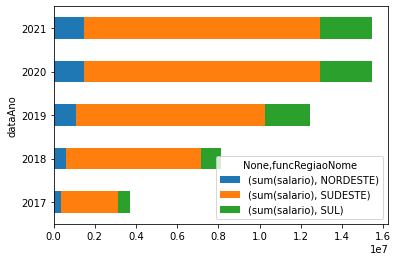

In [ ]:
# transformando o resultado da consulta em Pandas
pagAnoReg = resposta.toPandas()

# exibindo a visualização gráfica
# informando quais são os índices do DataFrame em Pandas 
pagAnoReg.set_index(['dataAno', 'funcRegiaoNome']).unstack(level = 1).plot(kind = 'barh', stacked = True)

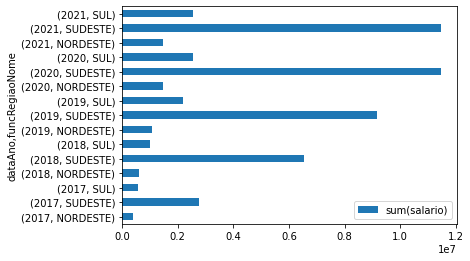

In [ ]:
# exibindo a visualização gráfica
# informando quais são os índices do DataFrame em Pandas 
pagAnoReg.set_index(['dataAno', 'funcRegiaoNome']).plot(kind = 'barh', stacked = True)

**Exemplo de consulta pivot:** Qual a soma dos salários, considerando as regiões nas quais os funcionários moram e cada ano? 

In [ ]:
resposta = pagamento\
   .join(data, on="dataPK")\
   .join(funcionario, on="funcPK")\
   .groupBy("funcRegiaoNome","dataAno")\
   .sum("salario")\
   .orderBy("funcRegiaoNome","dataAno")

resposta.show()

+--------------+-------+--------------------+
|funcRegiaoNome|dataAno|        sum(salario)|
+--------------+-------+--------------------+
|      NORDESTE|   2017|    374050.072265625|
|      NORDESTE|   2018|   611876.7509765625|
|      NORDESTE|   2019|  1077187.0737304688|
|      NORDESTE|   2020|  1471546.6713867188|
|      NORDESTE|   2021|  1471546.6713867188|
|       SUDESTE|   2017|  2747907.2373046875|
|       SUDESTE|   2018|   6535495.079589844|
|       SUDESTE|   2019|   9174504.465820312|
|       SUDESTE|   2020|1.1471309506347656E7|
|       SUDESTE|   2021|1.1471309506347656E7|
|           SUL|   2017|   580223.8681640625|
|           SUL|   2018|   998695.1821289062|
|           SUL|   2019|   2194580.490234375|
|           SUL|   2020|  2530199.1313476562|
|           SUL|   2021|  2530199.1313476562|
+--------------+-------+--------------------+



**Visualização Gráfica**: Exiba diferentes visualizações do resultado obtido.

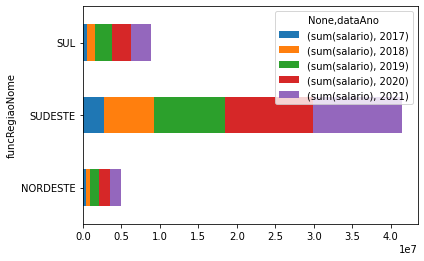

In [ ]:
# transformando o resultado da consulta em Pandas
pagRegAno = resposta.toPandas()

# exibindo a visualização gráfica
# informando quais são os índices do DataFrame em Pandas 
pagRegAno.set_index(['funcRegiaoNome', 'dataAno']).unstack(level = 1).plot(kind = 'barh', stacked = True)

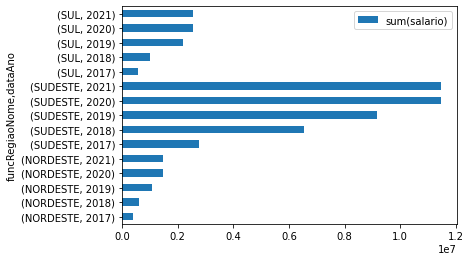

In [ ]:
pagRegAno.set_index(['funcRegiaoNome', 'dataAno']).plot(kind = 'barh')

### Método pivot()

`pivot(coluna, valores=None)`

Rotaciona uma `coluna` do `DataFrame`, e exibe os valores de acordo com o parâmetro `valores`.



In [ ]:
# repetindo a consulta base da operação pivot
resposta = pagamento\
   .join(data, on="dataPK")\
   .join(funcionario, on="funcPK")\
   .groupBy("dataAno", "funcRegiaoNome")\
   .sum("salario")\
   .orderBy("dataAno", "funcRegiaoNome")

# definindo o uso do método pivot()
respostaPivot = resposta\
   .groupBy("dataAno", "sum(salario)")\
   .pivot("funcRegiaoNome")\
   .sum("sum(salario)")

# exibindo o resultado gerado
respostaPivot.show()

+-------+--------------------+------------------+--------------------+------------------+
|dataAno|        sum(salario)|          NORDESTE|             SUDESTE|               SUL|
+-------+--------------------+------------------+--------------------+------------------+
|   2020|1.1471309506347656E7|              null|1.1471309506347656E7|              null|
|   2021|  2530199.1313476562|              null|                null|2530199.1313476562|
|   2019|   9174504.465820312|              null|   9174504.465820312|              null|
|   2018|   611876.7509765625| 611876.7509765625|                null|              null|
|   2020|  2530199.1313476562|              null|                null|2530199.1313476562|
|   2019|   2194580.490234375|              null|                null| 2194580.490234375|
|   2021|  1471546.6713867188|1471546.6713867188|                null|              null|
|   2018|   998695.1821289062|              null|                null| 998695.1821289062|
|   2019| 

## 5.4 Operação Drill-Across

**Definição:** Compara medidas numéricas de tabelas de fatos diferentes, utilizando pelo menos uma dimensão em comum. 

**Exemplo de consulta**: Qual a média dos salários e a média das receitas por equipe, considerando equipes que estejam localizadas na região Sudeste do Brasil?

In [ ]:
# resolvendo a primeira parte da consulta
# investigando a média dos salários das equipes
# localizadas na região Sudeste do Brasil

pag = pagamento\
   .join(equipe, on="equipePK")\
   .where("filialRegiaoNome = 'SUDESTE' AND filialPaisNome = 'BRASIL'")\
   .groupBy("equipePK")\
   .avg("salario")

pag.show()

+--------+-----------------+
|equipePK|     avg(salario)|
+--------+-----------------+
|       1|6446.264018554688|
|       6|8130.982067871094|
|       3|6289.158451960637|
|       9|6526.579498291016|
|       4|7321.892711292614|
|       7|7157.549323586856|
|       2|5894.339907226563|
+--------+-----------------+



In [ ]:
# resolvendo a segunda parte da consulta
# investigando a média das receitas das equipes
# localizadas na região Sudeste do Brasil

neg = negociacao\
   .join(equipe, on="equipePK")\
   .where("filialRegiaoNome = 'SUDESTE' AND filialPaisNome = 'BRASIL'")\
   .groupBy("equipePK")\
   .avg("receita")

neg.show() 

+--------+------------------+
|equipePK|      avg(receita)|
+--------+------------------+
|       1|15117.568975292079|
|       6|13519.745334934543|
|       3| 7211.691949879901|
|       9| 54854.55142857143|
|       4| 7342.084197105245|
|       7|12759.327950499488|
|       2|15282.249043841184|
+--------+------------------+



In [ ]:
# realizando a operação de drill-across
# exibindo o resultado final

resposta = pag\
   .join(neg, on="equipePK")\
   .orderBy("equipePK")

resposta.show()   

+--------+-----------------+------------------+
|equipePK|     avg(salario)|      avg(receita)|
+--------+-----------------+------------------+
|       1|6446.264018554688|15117.568975292079|
|       2|5894.339907226563|15282.249043841184|
|       3|6289.158451960637| 7211.691949879901|
|       4|7321.892711292614| 7342.084197105245|
|       6|8130.982067871094|13519.745334934543|
|       7|7157.549323586856|12759.327950499488|
|       9|6526.579498291016| 54854.55142857143|
+--------+-----------------+------------------+



**Visualização Gráfica**: Exiba diferentes visualizações do resultado obtido.

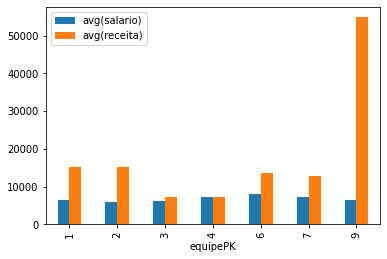

In [ ]:
# transformando o resultado da consulta em Pandas
equipeSalRec = resposta.toPandas()

# exibindo a visualização gráfica
# informando qual é o índice do DataFrame em Pandas 
equipeSalRec.set_index(['equipePK']).plot(kind = 'bar')

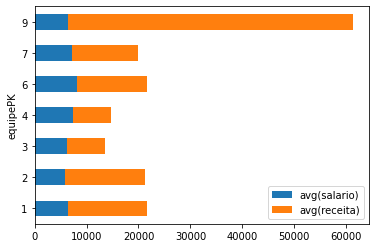

In [ ]:
# exibindo a visualização gráfica
# informando qual é o índice do DataFrame em Pandas
equipeSalRec.set_index(['equipePK']).plot(kind = 'barh', stacked = True)

### **Diferentes formas de se especificar uma consulta** 

Especificando o filtro no início da consulta.

In [ ]:
# selecionando apenas as equipes 
# localizadas na região Sudeste do Brasil
equipeReg = equipe\
   .where("filialRegiaoNome = 'SUDESTE' AND filialPaisNome = 'BRASIL'")

# resolvendo a primeira parte da consulta
# investigando a média dos salários das equipes
# localizadas na região Sudeste do Brasil
pag = pagamento\
   .join(equipeReg, on="equipePK")\
   .groupBy("equipePK")\
   .avg("salario")

# resolvendo a segunda parte da consulta
# investigando a média das receitas das equipes
# localizadas na região Sudeste do Brasil
neg = negociacao\
   .join(equipeReg, on="equipePK")\
   .groupBy("equipePK")\
   .avg("receita") 

# realizando a operação de drill-across
resposta = pag\
   .join(neg, on="equipePK")\
   .orderBy("equipePK")

# exibindo o resultado final
resposta.show()       

+--------+-----------------+------------------+
|equipePK|     avg(salario)|      avg(receita)|
+--------+-----------------+------------------+
|       1|6446.264018554688|15117.568975292079|
|       2|5894.339907226563|15282.249043841184|
|       3|6289.158451960637| 7211.691949879901|
|       4|7321.892711292614| 7342.084197105245|
|       6|8130.982067871094|13519.745334934543|
|       7|7157.549323586856|12759.327950499488|
|       9|6526.579498291016| 54854.55142857143|
+--------+-----------------+------------------+



Especificando apenas as colunas de interesse.

In [ ]:
# selecionando apenas as chaves primárias das equipes 
# localizadas na região Sudeste do Brasil
equipeReg = equipe\
   .where("filialRegiaoNome = 'SUDESTE' AND filialPaisNome = 'BRASIL'")\
   .select("equipePK")

# selecionando apenas os campos de interesse 
# do DataFrame pagamento
pagInteresse = pagamento\
   .select("equipePK", "salario")      

# resolvendo a primeira parte da consulta
# investigando a média dos salários das equipes
# localizadas na região Sudeste do Brasil
pag = pagInteresse\
   .join(equipeReg, on="equipePK")\
   .groupBy("equipePK")\
   .avg("salario")

# selecionando apenas os campos de interesse 
# do DataFrame negociacao
negInteresse = negociacao\
   .select("equipePK", "receita")    

# resolvendo a segunda parte da consulta
# investigando a média das receitas das equipes
# localizadas na região Sudeste do Brasil
neg = negInteresse\
   .join(equipeReg, on="equipePK")\
   .groupBy("equipePK")\
   .avg("receita") 

# realizando a operação de drill-across
resposta = pag\
   .join(neg, on="equipePK")\
   .orderBy("equipePK")

# exibindo o resultado final
resposta.show()

+--------+-----------------+------------------+
|equipePK|     avg(salario)|      avg(receita)|
+--------+-----------------+------------------+
|       1|6446.264018554688|15117.568975292079|
|       2|5894.339907226563|15282.249043841184|
|       3|6289.158451960637| 7211.691949879901|
|       4|7321.892711292614| 7342.084197105245|
|       6|8130.982067871094|13519.745334934543|
|       7|7157.549323586856|12759.327950499488|
|       9|6526.579498291016| 54854.55142857143|
+--------+-----------------+------------------+



Especificando as junções em outra ordem.

In [ ]:
# resolvendo a primeira parte da consulta
# investigando a média dos salários das equipes
pag = pagamento\
   .groupBy("equipePK")\
   .avg("salario")

# resolvendo a segunda parte da consulta
# investigando a média das receitas das equipes
neg = negociacao\
   .groupBy("equipePK")\
   .avg("receita") 

# realizando a operação de drill-across
resposta = pag\
   .join(neg, on="equipePK")\
   .orderBy("equipePK")

# selecionando apenas as equipes    
# localizadas na região Sudeste do Brasil
resposta = resposta\
   .join(equipe, on="equipePK")\
   .where("filialRegiaoNome = 'SUDESTE' AND filialPaisNome = 'BRASIL'")\
   .select("equipePK", "avg(salario)", "avg(receita)")

# exibindo o resultado final
resposta.show()

+--------+-----------------+------------------+
|equipePK|     avg(salario)|      avg(receita)|
+--------+-----------------+------------------+
|       1|6446.264018554688|15117.568975292079|
|       6|8130.982067871094|13519.745334934543|
|       3|6289.158451960637| 7211.691949879901|
|       9|6526.579498291016| 54854.55142857143|
|       4|7321.892711292614| 7342.084197105245|
|       7|7157.549323586856|12759.327950499488|
|       2|5894.339907226563|15282.249043841184|
+--------+-----------------+------------------+



## 5.5 Extensões ROLLUP e CUBE  

**Definição:** Constrém vários níveis de agregação.

- ROLLUP: criação de subtotais para as combinações dos atributos da lista de agrupamento de acordo com a ordem desses atributos. São criados n+1 níveis de agregação, sendo n o número de atributos especificados na lista de agrupamento.

- CUBE: criação de subtotais para todas as combinações dos atributos da lista de agrupamento. São criados 2ˆn (2 elevado a n) níveis, sendo n o número de atributos especificados na lista de agrupamento.



**Exemplo de consulta com ROLLUP:** Liste as agregações que podem ser geradas a partir da soma da receita por setor do cliente e por cidade do cliente, para totais de receita superiores a 3.000.000,00. Crie subtotais considerando a ordem dos atributos na lista de agrupamento.

In [ ]:
cliente.join(negociacao, on="clientePK")\
  .rollup("clienteSetor", "clienteCidade").sum("receita")\
  .filter("sum(receita) > 3000000")\
  .orderBy("clienteSetor", "clienteCidade")\
  .show()

+------------+--------------+--------------------+
|clienteSetor| clienteCidade|        sum(receita)|
+------------+--------------+--------------------+
|        null|          null| 7.792806753393555E7|
| ALIMENTACAO|          null|3.1113492538391113E7|
| ALIMENTACAO|BELO HORIZONTE|  3706999.6617126465|
| ALIMENTACAO|       MARILIA|  3615207.6019592285|
| ALIMENTACAO|        RECIFE|   3464283.962524414|
| ALIMENTACAO|RIO DE JANEIRO|   6413743.272583008|
| ALIMENTACAO|     SAO PAULO|    5355102.86730957|
|   BEM ESTAR|          null|1.5982756673492432E7|
|   BEM ESTAR|     SAO PAULO|   3483542.044555664|
|  FINANCEIRO|          null|   5710308.428527832|
| INFORMATICA|          null| 1.451290249282837E7|
| INFORMATICA|     SAO PAULO|   8027183.829315186|
|   VESTUARIO|          null|  1.06086074006958E7|
|   VESTUARIO|RIO DE JANEIRO|   5231977.989105225|
|   VESTUARIO|     SAO PAULO|   4105108.482696533|
+------------+--------------+--------------------+



**Exemplo de consulta com CUBE:** Liste todas as agregações que podem ser geradas a partir da soma da receita por setor do cliente e por cidade do cliente, para totais de receita superiores a 3.000.000,00.

In [ ]:
cliente.join(negociacao, on="clientePK")\
  .cube("clienteSetor", "clienteCidade").sum("receita")\
  .filter("sum(receita) > 3000000")\
  .orderBy("clienteSetor", "clienteCidade")\
  .show(40)

+------------+--------------+--------------------+
|clienteSetor| clienteCidade|        sum(receita)|
+------------+--------------+--------------------+
|        null|          null| 7.792806753393555E7|
|        null|BELO HORIZONTE|   3861877.413848877|
|        null|      CURITIBA|   3166106.860900879|
|        null|        MANAUS|   4531776.252197266|
|        null|       MARILIA|   6518904.231536865|
|        null|  PORTO ALEGRE|  3757225.1489257812|
|        null|        RECIFE|   4195951.329772949|
|        null|RIO DE JANEIRO|1.3314086880828857E7|
|        null|    SAO CARLOS|   3715812.712585449|
|        null|     SAO PAULO|2.1506742080322266E7|
|        null|    UBERLANDIA|   3912375.795776367|
| ALIMENTACAO|          null|3.1113492538391113E7|
| ALIMENTACAO|BELO HORIZONTE|  3706999.6617126465|
| ALIMENTACAO|       MARILIA|  3615207.6019592285|
| ALIMENTACAO|        RECIFE|   3464283.962524414|
| ALIMENTACAO|RIO DE JANEIRO|   6413743.272583008|
| ALIMENTACAO|     SAO PAULO|  

## 5.6 Funções de Janela

**Definição:** Uma função de janela opera em um grupo de tuplas, chamado de janela ou partição, calculando um valor de retorno para cada tupla com base no grupo de tuplas da partição.

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import avg, col, lead, row_number, lag

**Exemplo de consulta com AVG (1):** Para cada funcionário e cada data, mostre o seu salário ao lado das médias de todos os salários pagos.

In [ ]:
# determinando para cada funcionário e cada data, o salário
funcData = pagamento\
   .join(data, on= "dataPK")\
   .join(funcionario, on= "funcPK")\
   .select("funcNome", "dataCompleta", "salario") 

# criando a janela (partição)
window = Window.orderBy()

# calculando a média dos salários sobre a partição
resposta = funcData\
   .withColumn("mediaSalario", avg(col("salario")).over(window))

resposta.show(5)  

+----------------+------------+-------+-----------------+
|        funcNome|dataCompleta|salario|     mediaSalario|
+----------------+------------+-------+-----------------+
|  SANDRA GREGORY|  05/01/2017|1299.95|6393.591532219781|
| JEROLD GOODHART|  05/01/2017|6752.31|6393.591532219781|
|       JACK ROSS|  05/01/2017|2110.43|6393.591532219781|
|  JOSEPH CADDICK|  05/01/2017|6568.92|6393.591532219781|
|MALCOLM CONNEALY|  05/01/2017|3670.49|6393.591532219781|
+----------------+------------+-------+-----------------+
only showing top 5 rows



**Exemplo de consulta com AVG (2):** Para cada funcionário e cada data, mostre o seu salário ao lado das médias de todos os salários pagos naquela data. 

In [ ]:
# determinando para cada funcionário e cada data, o salário
funcData = pagamento\
   .join(data, on= "dataPK")\
   .join(funcionario, on= "funcPK")\
   .select("funcNome", "dataCompleta", "salario") 

# criando a janela (partição)
window = Window.partitionBy("dataCompleta").orderBy()

# calculando a média dos salários sobre a partição
resposta = funcData\
   .withColumn("mediaSalarioData", avg(col("salario")).over(window))

resposta.show(5) 

+----------------+------------+-------+------------------+
|        funcNome|dataCompleta|salario|  mediaSalarioData|
+----------------+------------+-------+------------------+
|  SANDRA GREGORY|  05/11/2020|1299.95|6447.1063787841795|
| JEROLD GOODHART|  05/11/2020|6752.31|6447.1063787841795|
|       JACK ROSS|  05/11/2020|2110.43|6447.1063787841795|
|  JOSEPH CADDICK|  05/11/2020|6568.92|6447.1063787841795|
|MALCOLM CONNEALY|  05/11/2020|3670.49|6447.1063787841795|
+----------------+------------+-------+------------------+
only showing top 5 rows



**Exemplo de consulta com ROW_NUMBER:** Mostre para a funcionária MARGARET HENDERSON, as datas e os salários que ela recebeu, bem como a ordem em que recebeu esses salários.

In [ ]:
# determinando para os salários para a funcionária especificada
funcData = pagamento\
   .join(data, on= "dataPK")\
   .join(funcionario, on= "funcPK")\
   .where("funcNome = 'MARGARET HENDERSON'")

# criando a janela (partição)
window = Window.partitionBy("funcPK").orderBy("dataPK")

# calculando a média dos salários sobre a partição
resposta = funcData\
   .withColumn("ordem", row_number().over(window))\

# exibindo a resposta solicitada
resposta\
   .select("dataCompleta", "salario", "ordem")\
   .show(5) 

+------------+--------+-----+
|dataCompleta| salario|ordem|
+------------+--------+-----+
|  05/01/2019|20013.64|    1|
|  05/02/2019|20013.64|    2|
|  05/03/2019|20013.64|    3|
|  05/04/2019|20013.64|    4|
|  05/05/2019|20013.64|    5|
+------------+--------+-----+
only showing top 5 rows



**Exemplo de consulta com LEAD:** Mostre para a funcionária MARGARET HENDERSON, as datas e os salários que ela recebeu naquela data, bem como o salário que ela recebeu na próxima data.

In [ ]:
# determinando para os salários para a funcionária especificada
funcData = pagamento\
   .join(data, on= "dataPK")\
   .join(funcionario, on= "funcPK")\
   .where("funcNome = 'MARGARET HENDERSON'")

# criando a janela (partição)
window = Window.partitionBy("funcPK").orderBy("dataPK")

# calculando a média dos salários sobre a partição
resposta = funcData\
   .withColumn("salário próximo mês", lead("salario").over(window))\

# exibindo a resposta solicitada
resposta\
   .select("dataCompleta", "salario", "salário próximo mês")\
   .show(40) 

+------------+--------+-------------------+
|dataCompleta| salario|salário próximo mês|
+------------+--------+-------------------+
|  05/01/2019|20013.64|           20013.64|
|  05/02/2019|20013.64|           20013.64|
|  05/03/2019|20013.64|           20013.64|
|  05/04/2019|20013.64|           20013.64|
|  05/05/2019|20013.64|           20013.64|
|  05/06/2019|20013.64|           20013.64|
|  05/07/2019|20013.64|           20013.64|
|  05/08/2019|20013.64|           20013.64|
|  05/09/2019|20013.64|           20013.64|
|  05/10/2019|20013.64|           20013.64|
|  05/11/2019|20013.64|           20013.64|
|  05/12/2019|20013.64|           20013.64|
|  05/01/2020|20013.64|           20013.64|
|  05/02/2020|20013.64|           20013.64|
|  05/03/2020|20013.64|           20013.64|
|  05/04/2020|20013.64|           20013.64|
|  05/05/2020|20013.64|           20013.64|
|  05/06/2020|20013.64|           20013.64|
|  05/07/2020|20013.64|           20013.64|
|  05/08/2020|20013.64|         

**Exemplo de consulta com LAG:** Mostre para a funcionária MARGARET HENDERSON, as datas e os salários que ela recebeu naquela data, bem como o salário que ela recebeu na data anterior.

In [ ]:
# calculando a média dos salários sobre a partição
resposta = funcData\
   .withColumn("salário mês anterior", lag("salario").over(window))\

# exibindo a resposta solicitada
resposta\
   .select("dataCompleta", "salario", "salário mês anterior")\
   .show(40) 

+------------+--------+--------------------+
|dataCompleta| salario|salário mês anterior|
+------------+--------+--------------------+
|  05/01/2019|20013.64|                null|
|  05/02/2019|20013.64|            20013.64|
|  05/03/2019|20013.64|            20013.64|
|  05/04/2019|20013.64|            20013.64|
|  05/05/2019|20013.64|            20013.64|
|  05/06/2019|20013.64|            20013.64|
|  05/07/2019|20013.64|            20013.64|
|  05/08/2019|20013.64|            20013.64|
|  05/09/2019|20013.64|            20013.64|
|  05/10/2019|20013.64|            20013.64|
|  05/11/2019|20013.64|            20013.64|
|  05/12/2019|20013.64|            20013.64|
|  05/01/2020|20013.64|            20013.64|
|  05/02/2020|20013.64|            20013.64|
|  05/03/2020|20013.64|            20013.64|
|  05/04/2020|20013.64|            20013.64|
|  05/05/2020|20013.64|            20013.64|
|  05/06/2020|20013.64|            20013.64|
|  05/07/2020|20013.64|            20013.64|
|  05/08/2

# 6 Semântica das Respostas

As consultas OLAP requisitadas por usuários de sistemas de suporte à decisão usualmente requerem que várias operações OLAP sejam realizadas simultaneamente. Adicionalmente, esses usuários também podem querer:

- Que resultados mais semânticos sejam exibidos.

- Que os dados numéricos de ponto flutuante sejam arredondados para facilitar a visualização.

- Que as linhas dos relatórios sejam exibidas de forma ordenada.

- Que valores derivados sejam calculados e exibidos. 

- Que as colunas dos relatórios possuam nomes semânticos para facilitar o entendimento.

**Consulta drill-across:** Qual a média dos salários e a média das receitas por equipe, considerando equipes que estejam localizadas na região Sudeste do Brasil?

In [ ]:
# investigando a média dos salários das equipes
# localizadas na região Nordeste do Brasil
# retornando apenas o atributo equipePK
equipeReg = equipe\
   .where("filialRegiaoNome = 'SUDESTE' AND filialPaisNome = 'BRASIL'")\
   .select("equipePK")

# resolvendo a primeira parte da consulta
pag = pagamento\
   .join(equipeReg, on="equipePK")\
   .select("equipePK", "salario")\
   .groupBy("equipePK")\
   .avg("salario")

# resolvendo a segunda parte da consulta
neg = negociacao\
   .join(equipeReg, on="equipePK")\
   .select("equipePK", "receita")\
   .groupBy("equipePK")\
   .avg("receita") 

# realizando a operação de drill-across
resposta = pag\
   .join(neg, on="equipePK")\
   .orderBy("equipePK")  

# exibindo a resposta
resposta.show()            

+--------+-----------------+------------------+
|equipePK|     avg(salario)|      avg(receita)|
+--------+-----------------+------------------+
|       1|6446.264018554688|15117.568975292079|
|       2|5894.339907226563|15282.249043841184|
|       3|6289.158451960637| 7211.691949879901|
|       4|7321.892711292614| 7342.084197105245|
|       6|8130.982067871094|13519.745334934543|
|       7|7157.549323586856|12759.327950499488|
|       9|6526.579498291016| 54854.55142857143|
+--------+-----------------+------------------+



In [ ]:
# exibindo resultados mais semânticos
# adicionando os nomes das equipes
resposta = resposta\
   .join(equipe, on="equipePK")\
   .select("equipePK", "equipeNome", "filialNome", "avg(salario)", "avg(receita)")

# exibindo a resposta
resposta.show() 


+--------+----------------+--------------------+-----------------+------------------+
|equipePK|      equipeNome|          filialNome|     avg(salario)|      avg(receita)|
+--------+----------------+--------------------+-----------------+------------------+
|       1|    SERVICO PLUS|SAO PAULO - IPIRANGA|6446.264018554688|15117.568975292079|
|       6|SERVICO STANDARD|SAO PAULO - IPIRANGA|8130.982067871094|13519.745334934543|
|       3|   SERVICO BASIC|SAO PAULO - IPIRANGA|6289.158451960637| 7211.691949879901|
|       9| SERVICO PREMIUM|SAO PAULO - IPIRANGA|6526.579498291016| 54854.55142857143|
|       4|   SERVICO BASIC|RIO DE JANEIRO - ...|7321.892711292614| 7342.084197105245|
|       7|SERVICO STANDARD|RIO DE JANEIRO - ...|7157.549323586856|12759.327950499488|
|       2|    SERVICO PLUS|RIO DE JANEIRO - ...|5894.339907226563|15282.249043841184|
+--------+----------------+--------------------+-----------------+------------------+



In [ ]:
# arredondando os dados numéricos de ponto flutuante

from pyspark.sql.functions import round

resposta = resposta\
   .withColumn("avg(salario)", round("avg(salario)",2))\
   .withColumn("avg(receita)", round("avg(receita)",2))

# exibindo a resposta
resposta.show()    

+--------+----------------+--------------------+------------+------------+
|equipePK|      equipeNome|          filialNome|avg(salario)|avg(receita)|
+--------+----------------+--------------------+------------+------------+
|       1|    SERVICO PLUS|SAO PAULO - IPIRANGA|     6446.26|    15117.57|
|       6|SERVICO STANDARD|SAO PAULO - IPIRANGA|     8130.98|    13519.75|
|       3|   SERVICO BASIC|SAO PAULO - IPIRANGA|     6289.16|     7211.69|
|       9| SERVICO PREMIUM|SAO PAULO - IPIRANGA|     6526.58|    54854.55|
|       4|   SERVICO BASIC|RIO DE JANEIRO - ...|     7321.89|     7342.08|
|       7|SERVICO STANDARD|RIO DE JANEIRO - ...|     7157.55|    12759.33|
|       2|    SERVICO PLUS|RIO DE JANEIRO - ...|     5894.34|    15282.25|
+--------+----------------+--------------------+------------+------------+



In [ ]:
# ordenando os resultados pelas maiores receitas em ordem decrescente

from pyspark.sql.functions import desc

resposta = resposta\
   .orderBy(desc("avg(receita)"))

# exibindo a resposta
resposta.show()   

+--------+----------------+--------------------+------------+------------+
|equipePK|      equipeNome|          filialNome|avg(salario)|avg(receita)|
+--------+----------------+--------------------+------------+------------+
|       9| SERVICO PREMIUM|SAO PAULO - IPIRANGA|     6526.58|    54854.55|
|       2|    SERVICO PLUS|RIO DE JANEIRO - ...|     5894.34|    15282.25|
|       1|    SERVICO PLUS|SAO PAULO - IPIRANGA|     6446.26|    15117.57|
|       6|SERVICO STANDARD|SAO PAULO - IPIRANGA|     8130.98|    13519.75|
|       7|SERVICO STANDARD|RIO DE JANEIRO - ...|     7157.55|    12759.33|
|       4|   SERVICO BASIC|RIO DE JANEIRO - ...|     7321.89|     7342.08|
|       3|   SERVICO BASIC|SAO PAULO - IPIRANGA|     6289.16|     7211.69|
+--------+----------------+--------------------+------------+------------+



In [ ]:
# calculando valores derivados

resposta = resposta\
   .withColumn("diferenca", resposta["avg(receita)"] - resposta["avg(salario)"])\
   .withColumn("diferenca", round("diferenca",2))

# exibindo a resposta
resposta.show()   

+--------+----------------+--------------------+------------+------------+---------+
|equipePK|      equipeNome|          filialNome|avg(salario)|avg(receita)|diferenca|
+--------+----------------+--------------------+------------+------------+---------+
|       9| SERVICO PREMIUM|SAO PAULO - IPIRANGA|     6526.58|    54854.55| 48327.97|
|       2|    SERVICO PLUS|RIO DE JANEIRO - ...|     5894.34|    15282.25|  9387.91|
|       1|    SERVICO PLUS|SAO PAULO - IPIRANGA|     6446.26|    15117.57|  8671.31|
|       6|SERVICO STANDARD|SAO PAULO - IPIRANGA|     8130.98|    13519.75|  5388.77|
|       7|SERVICO STANDARD|RIO DE JANEIRO - ...|     7157.55|    12759.33|  5601.78|
|       4|   SERVICO BASIC|RIO DE JANEIRO - ...|     7321.89|     7342.08|    20.19|
|       3|   SERVICO BASIC|SAO PAULO - IPIRANGA|     6289.16|     7211.69|   922.53|
+--------+----------------+--------------------+------------+------------+---------+



In [ ]:
# renomeando os nomes das colunas 
resposta = resposta\
   .withColumnRenamed("equipePK", "Código")\
   .withColumnRenamed("equipeNome", "Nome da Equipe")\
   .withColumnRenamed("filialNome", "Nome da Filial")\
   .withColumnRenamed("avg(salario)", "Gastos com Salários")\
   .withColumnRenamed("avg(receita)", "Ganhos em Receitas")\
   .withColumnRenamed("diferenca", "Lucro ou Prejuízo")   

# exibindo a resposta
resposta.show()      

+------+----------------+--------------------+-------------------+------------------+-----------------+
|Código|  Nome da Equipe|      Nome da Filial|Gastos com Salários|Ganhos em Receitas|Lucro ou Prejuízo|
+------+----------------+--------------------+-------------------+------------------+-----------------+
|     9| SERVICO PREMIUM|SAO PAULO - IPIRANGA|            6526.58|          54854.55|         48327.97|
|     2|    SERVICO PLUS|RIO DE JANEIRO - ...|            5894.34|          15282.25|          9387.91|
|     1|    SERVICO PLUS|SAO PAULO - IPIRANGA|            6446.26|          15117.57|          8671.31|
|     6|SERVICO STANDARD|SAO PAULO - IPIRANGA|            8130.98|          13519.75|          5388.77|
|     7|SERVICO STANDARD|RIO DE JANEIRO - ...|            7157.55|          12759.33|          5601.78|
|     4|   SERVICO BASIC|RIO DE JANEIRO - ...|            7321.89|           7342.08|            20.19|
|     3|   SERVICO BASIC|SAO PAULO - IPIRANGA|            6289.1